In [2]:
import matplotlib.pyplot as plt
import numpy as np
from pandas import read_csv
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import MDS
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import mne
from mne.datasets import visual_92_categories
from mne.io import concatenate_raws, read_raw_fif

print(__doc__)

data_path = visual_92_categories.data_path()

# Define stimulus - trigger mapping
fname = data_path / "visual_stimuli.csv"
conds = read_csv(fname)
print(conds.head(5))
type(data_path)

Automatically created module for IPython interactive environment
   trigger       condition  human  face  animal  natural
0        0  human bodypart      1     0       1        1
1        1  human bodypart      1     0       1        1
2        2  human bodypart      1     0       1        1
3        3  human bodypart      1     0       1        1
4        4  human bodypart      1     0       1        1


pathlib.PosixPath

In [4]:
max_trigger = 24
conds = conds[:max_trigger]  # take only the first 24 rows

In [5]:
conditions = []
for c in conds.values:
    cond_tags = list(c[:2])
    cond_tags += [
        ("not-" if i == 0 else "") + conds.columns[k] for k, i in enumerate(c[2:], 2)
    ]
    conditions.append("/".join(map(str, cond_tags)))
print(conditions[:10])

['0/human bodypart/human/not-face/animal/natural', '1/human bodypart/human/not-face/animal/natural', '2/human bodypart/human/not-face/animal/natural', '3/human bodypart/human/not-face/animal/natural', '4/human bodypart/human/not-face/animal/natural', '5/human bodypart/human/not-face/animal/natural', '6/human bodypart/human/not-face/animal/natural', '7/human bodypart/human/not-face/animal/natural', '8/human bodypart/human/not-face/animal/natural', '9/human bodypart/human/not-face/animal/natural']


In [6]:
event_id = dict(zip(conditions, conds.trigger + 1))
event_id["0/human bodypart/human/not-face/animal/natural"]

1

In [7]:
n_runs = 4  # 4 for full data (use less to speed up computations)
fnames = [data_path / f"sample_subject_{b}_tsss_mc.fif" for b in range(n_runs)]
raws = [
    read_raw_fif(fname, verbose="error", on_split_missing="ignore") for fname in fnames
]  # ignore filename warnings
raw = concatenate_raws(raws)

events = mne.find_events(raw, min_duration=0.002)

events = events[events[:, 2] <= max_trigger]

4142 events found on stim channel STI101
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93 200 222 244]


In [8]:
picks = mne.pick_types(raw.info, meg=True)
epochs = mne.Epochs(
    raw,
    events=events,
    event_id=event_id,
    baseline=None,
    picks=picks,
    tmin=-0.1,
    tmax=0.500,
    preload=True,
)

Not setting metadata
720 matching events found
No baseline correction applied
0 projection items activated
Loading data for 720 events and 601 original time points ...
0 bad epochs dropped


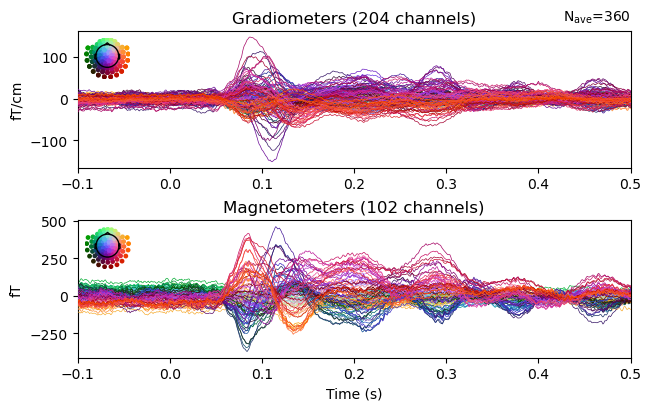

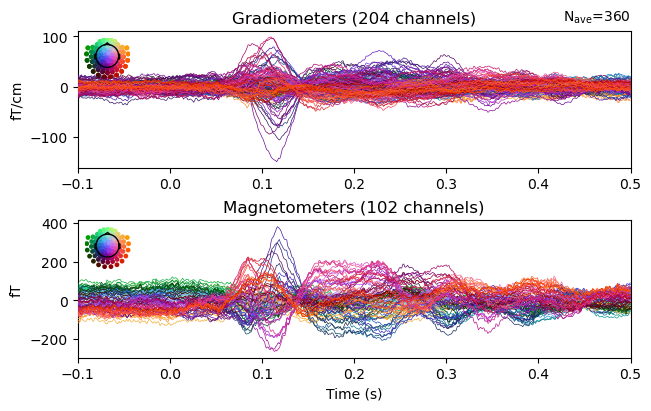

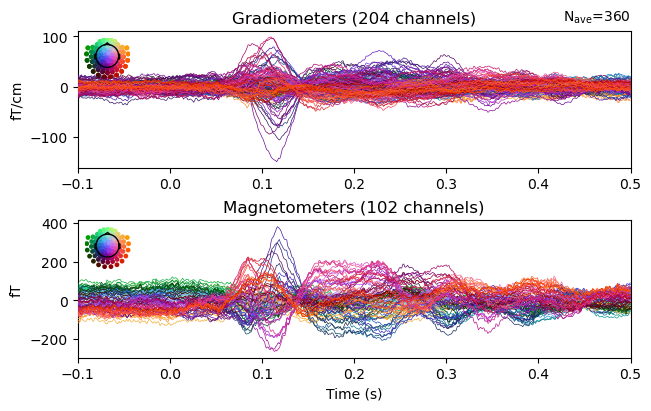

In [9]:
epochs["face"].average().plot()
epochs["not-face"].average().plot()

In [10]:
# Classify using the average signal in the window 50ms to 300ms
# to focus the classifier on the time interval with best SNR.
clf = make_pipeline(
    StandardScaler(), LogisticRegression(C=1, solver="liblinear", multi_class="auto")
)
X = epochs.copy().crop(0.05, 0.3).get_data().mean(axis=2)
y = epochs.events[:, 2]

classes = set(y)
cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

# Compute confusion matrix for each cross-validation fold
y_pred = np.zeros((len(y), len(classes)))
for train, test in cv.split(X, y):
    # Fit
    clf.fit(X[train], y[train])
    # Probabilistic prediction (necessary for ROC-AUC scoring metric)
    y_pred[test] = clf.predict_proba(X[test])

/var/folders/y_/m3qn82z15yb4fhdtdwn9vp_h0000gq/T/ipykernel_2904/3373230612.py:6: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X = epochs.copy().crop(0.05, 0.3).get_data().mean(axis=2)


In [11]:
confusion = np.zeros((len(classes), len(classes)))
for ii, train_class in enumerate(classes):
    for jj in range(ii, len(classes)):
        confusion[ii, jj] = roc_auc_score(y == train_class, y_pred[:, jj])
        confusion[jj, ii] = confusion[ii, jj]

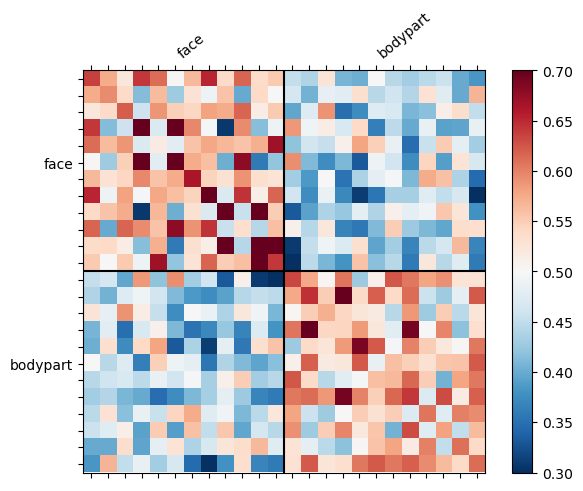

In [12]:
labels = [""] * 5 + ["face"] + [""] * 11 + ["bodypart"] + [""] * 6
fig, ax = plt.subplots(1, layout="constrained")
im = ax.matshow(confusion, cmap="RdBu_r", clim=[0.3, 0.7])
ax.set_yticks(range(len(classes)))
ax.set_yticklabels(labels)
ax.set_xticks(range(len(classes)))
ax.set_xticklabels(labels, rotation=40, ha="left")
ax.axhline(11.5, color="k")
ax.axvline(11.5, color="k")
plt.colorbar(im)
plt.show()

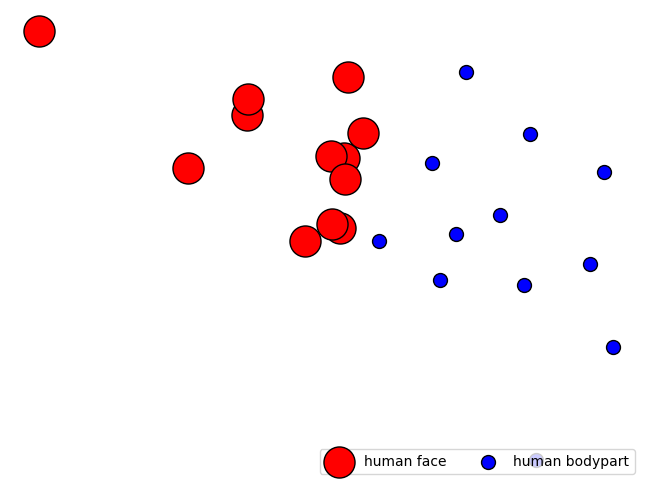

In [13]:
fig, ax = plt.subplots(1, layout="constrained")
mds = MDS(2, random_state=0, dissimilarity="precomputed")
chance = 0.5
summary = mds.fit_transform(chance - confusion)
cmap = plt.colormaps["rainbow"]
colors = ["r", "b"]
names = list(conds["condition"].values)
for color, name in zip(colors, set(names)):
    sel = np.where([this_name == name for this_name in names])[0]
    size = 500 if name == "human face" else 100
    ax.scatter(
        summary[sel, 0],
        summary[sel, 1],
        s=size,
        facecolors=color,
        label=name,
        edgecolors="k",
    )
ax.axis("off")
ax.legend(loc="lower right", scatterpoints=1, ncol=2)
plt.show()